In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
inspector = inspect(engine)
inspector
# Use inspector to view table details
for table_name in inspector.get_table_names():
    for column in inspector.get_columns(table_name):
        print( table_name,": ", column.get('name'), ", ", column.get('type'))

measurement :  id ,  INTEGER
measurement :  station ,  TEXT
measurement :  date ,  TEXT
measurement :  prcp ,  FLOAT
measurement :  tobs ,  FLOAT
station :  id ,  INTEGER
station :  station ,  TEXT
station :  name ,  TEXT
station :  latitude ,  FLOAT
station :  longitude ,  FLOAT
station :  elevation ,  FLOAT


# Exploratory Climate Analysis

In [13]:

most_recent_date = session.query(Measurement.date)\
    .order_by(Measurement.date.desc()).first()
rec_date = str(most_recent_date)[2:-3]
year_ago = str(eval(rec_date[0:4])-1) + rec_date[4:]
year_ago

'2016-08-23'

In [17]:
test_precip_twelve = session.query(Measurement.date,
                                   func.avg(Measurement.prcp))\
                                    .filter(Measurement.date > year_ago)\
                                    .group_by(Measurement.date)\
                                    .order_by(Measurement.date).all()
    
for row in test_precip_twelve:
    print(row)

('2016-08-24', 1.5549999999999997)
('2016-08-25', 0.07714285714285715)
('2016-08-26', 0.016666666666666666)
('2016-08-27', 0.06399999999999999)
('2016-08-28', 0.5166666666666666)
('2016-08-29', 0.24333333333333332)
('2016-08-30', 0.011666666666666667)
('2016-08-31', 0.6359999999999999)
('2016-09-01', 0.006)
('2016-09-02', 0.05)
('2016-09-03', 0.254)
('2016-09-04', 0.276)
('2016-09-05', 0.08499999999999999)
('2016-09-06', 0.246)
('2016-09-07', 0.3333333333333333)
('2016-09-08', 0.07666666666666667)
('2016-09-09', 0.17833333333333332)
('2016-09-10', 0.27999999999999997)
('2016-09-11', 0.25)
('2016-09-12', 0.308)
('2016-09-13', 0.45166666666666666)
('2016-09-14', 2.3800000000000003)
('2016-09-15', 0.8266666666666667)
('2016-09-16', 0.11714285714285715)
('2016-09-17', 0.13599999999999998)
('2016-09-18', 0.10600000000000001)
('2016-09-19', 0.064)
('2016-09-20', 0.14714285714285716)
('2016-09-21', 0.19499999999999998)
('2016-09-22', 0.2057142857142857)
('2016-09-23', 0.22428571428571428)
('2

In [18]:
precip = pd.DataFrame(test_precip_twelve, columns=['date','prcp'])
precip['date'] = pd.to_datetime(precip['date'], format='%Y/%m/%d')
precip.sort_values(by=['date'])
precip.head()

,date,prcp
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


In [19]:
precip.set_index('date', inplace=True)

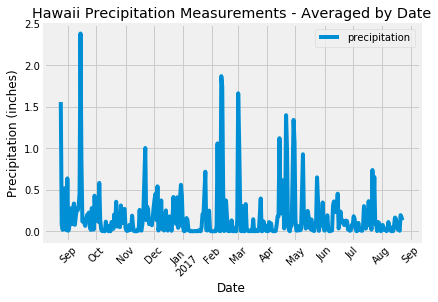

In [20]:
# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
precip.plot(use_index=True, y='prcp')
plt.title("Hawaii Precipitation Measurements - Averaged by Date")
plt.xlabel(f"Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.legend(["precipitation"],loc=1)
plt.savefig('precipitation_amounts.png')

In [46]:
#Use Pandas to print the summary statistics for the precipitation data.
precip.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [22]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id,Station.station,Station.name)
print(f"There are {stations.count()} stations.")

There are 9 stations.


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activity = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc())

for row in activity:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [26]:
# Station with the highest activity
highest_activity = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).limit(1).scalar()

highest_activity

'USC00519281'

In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps = session.query(Station.id,
                  Station.name,
                  func.min(Measurement.tobs),
                  func.max(Measurement.tobs),
                  func.avg(Measurement.tobs))\
.filter(Measurement.station == Station.station)\
.filter(Measurement.station == "USC00519281")
avg_tmp_rec = "{0:.1f}".format(temps[0][4])
print(f"Minimum temperature recorded:  {temps[0][2]}\n\
    Maximum temperture recorded :  {temps[0][3]}\n    Average temperature recorded:  {avg_tmp_rec}")

Minimum temperature recorded:  54.0
    Maximum temperture recorded :  85.0
    Average temperature recorded:  71.7


In [39]:
temp_obs = session.query(Measurement.tobs)\
    .filter(Measurement.date > year_ago)\
    .filter(Measurement.station == highest_activity)\
    .order_by(Measurement.tobs).all()
    
for row in temp_obs:
    print(row)

(59.0,)
(59.0,)
(59.0,)
(60.0,)
(60.0,)
(61.0,)
(62.0,)
(62.0,)
(62.0,)
(62.0,)
(62.0,)
(62.0,)
(63.0,)
(63.0,)
(63.0,)
(63.0,)
(64.0,)
(64.0,)
(64.0,)
(65.0,)
(65.0,)
(65.0,)
(65.0,)
(65.0,)
(65.0,)
(65.0,)
(66.0,)
(66.0,)
(66.0,)
(66.0,)
(66.0,)
(67.0,)
(67.0,)
(67.0,)
(67.0,)
(67.0,)
(67.0,)
(67.0,)
(67.0,)
(67.0,)
(67.0,)
(67.0,)
(67.0,)
(67.0,)
(67.0,)
(67.0,)
(68.0,)
(68.0,)
(68.0,)
(68.0,)
(68.0,)
(68.0,)
(68.0,)
(68.0,)
(68.0,)
(68.0,)
(68.0,)
(68.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(69.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(70.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(71.0,)
(72.0,)
(72.0,)
(72.0,)
(72.0,)
(72.0,)
(72.0,)
(72.0,)
(72.0,)


In [41]:
tobs_df = pd.DataFrame(temp_obs, columns=['temp'])
tobs_df.head()

,temp
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


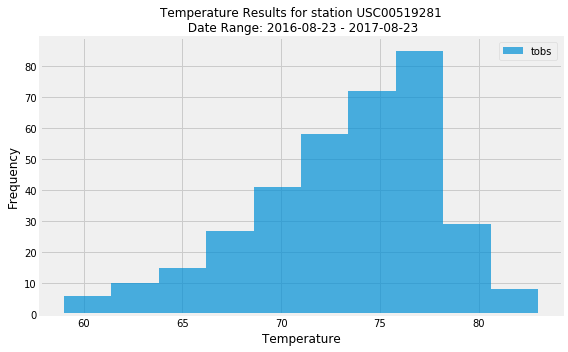

In [50]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.subplots(figsize=(8,5))

plt.hist(tobs_df['temp'], alpha=.7)
plt.title(f"Temperature Results for station {highest_activity}\n Date Range: \
{year_ago} - {rec_date}",fontsize=12)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel("Frequency", fontsize=12)
labels = ['tobs']
plt.legend(labels)
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.savefig('temperature_results_hist.png')
plt.show()

In [51]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [54]:
# calculate the min/max/avg from last year that matches my trip date
arrive = dt.date(2018, 6, 1)
leave = dt.date(2018, 6, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((arrive-last_year), (leave-last_year)))
print(temp_avg_lst_year)

[(72.0, 77.42268041237114, 83.0)]


<IPython.core.display.Javascript object>


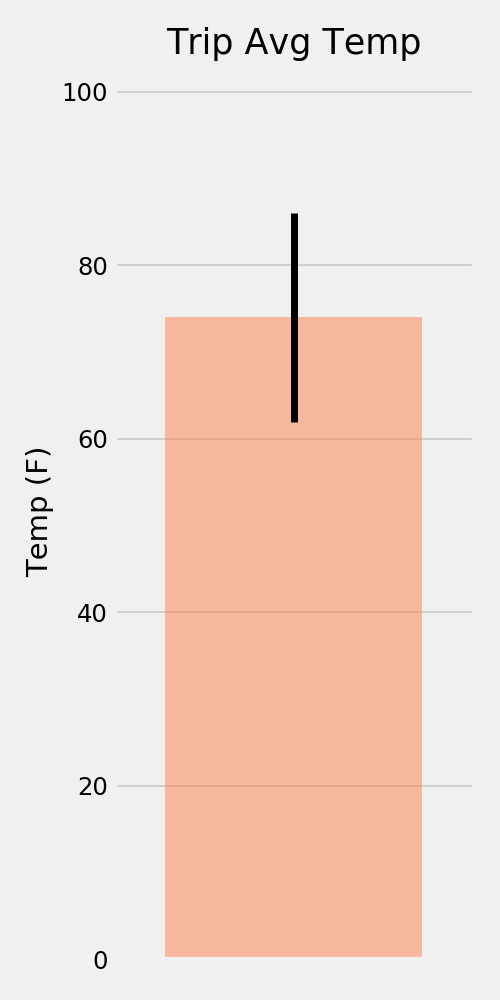

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [52]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [53]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


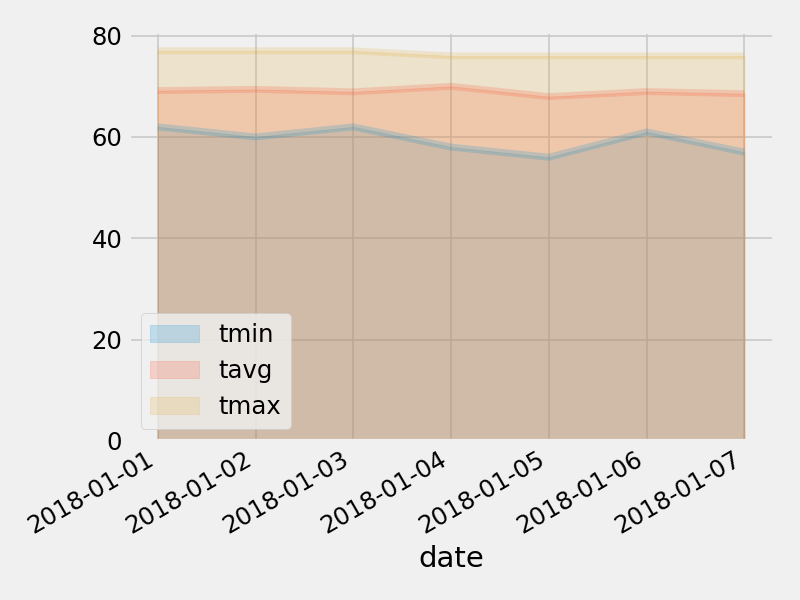

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
